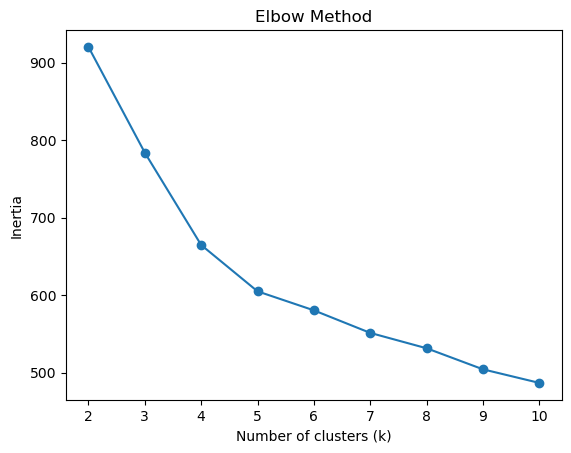

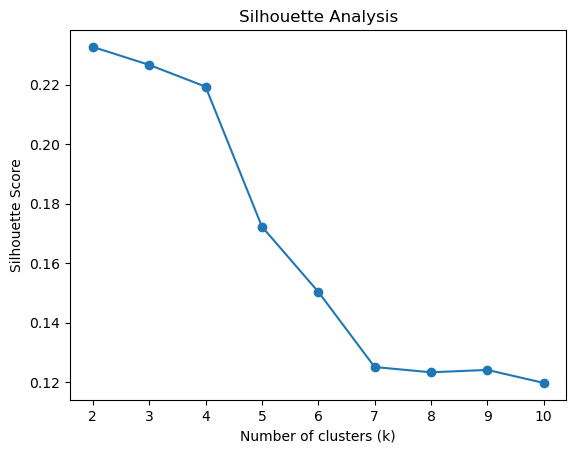

DB Index (k=4): 1.408302803169782


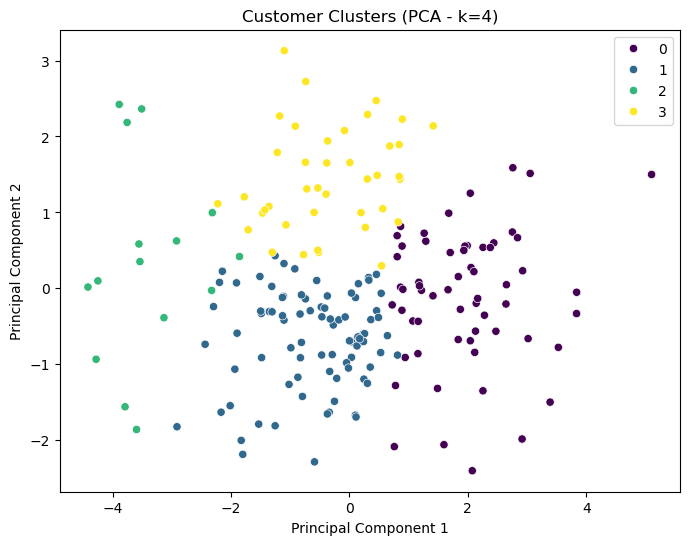


Cluster 0 Characteristics:
          Recency  Frequency  MonetaryValue  AvgTransactionValue  \
count   60.000000  60.000000      60.000000            60.000000   
mean    50.533333   7.616667    5372.240500           713.520849   
std     41.388391   1.290009    1414.516583           167.456306   
min      0.000000   6.000000    2315.480000           289.435000   
25%     11.000000   7.000000    4510.265000           607.270625   
50%     44.000000   8.000000    5305.725000           734.903750   
75%     83.750000   8.000000    6066.562500           825.267708   
max    135.000000  11.000000   10673.870000          1081.844286   

       UniqueProducts  
count       60.000000  
mean         7.266667  
std          1.132968  
min          6.000000  
25%          6.000000  
50%          7.000000  
75%          8.000000  
max         10.000000  

Cluster 1 Characteristics:
          Recency  Frequency  MonetaryValue  AvgTransactionValue  \
count   84.000000  84.000000      84.000000    

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Load data
customers = pd.read_csv("Customers.csv")
products = pd.read_csv("Products.csv")
transactions = pd.read_csv("Transactions.csv")

# Merge data
df = pd.merge(transactions, customers, on="CustomerID", how="left")
df = pd.merge(df, products, on="ProductID", how="left")

# Feature Engineering
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
df['SignupDate'] = pd.to_datetime(df['SignupDate'])
latest_date = df['TransactionDate'].max()
df['Recency'] = (latest_date - df['TransactionDate']).dt.days
df_agg = df.groupby('CustomerID').agg({
    'Recency': 'min',
    'TransactionID': 'count',
    'TotalValue': 'sum',
    'ProductName': 'nunique'
}).rename(columns={'TransactionID': 'Frequency', 'TotalValue': 'MonetaryValue', 'ProductName':'UniqueProducts'})

df_agg['AvgTransactionValue'] = df_agg['MonetaryValue'] / df_agg['Frequency']

# Preferred Category
preferred_category = df.groupby('CustomerID')['Category'].agg(lambda x: pd.Series.mode(x)[0] if not pd.Series(x).empty else None).reset_index()
df_agg = pd.merge(df_agg, preferred_category, on="CustomerID", how="left")
df_agg = pd.merge(df_agg, customers[['CustomerID','Region']], on='CustomerID', how='left')

df_agg = df_agg.reset_index()

# Preprocessing
numerical_features = ['Recency', 'Frequency', 'MonetaryValue', 'AvgTransactionValue','UniqueProducts']
categorical_features = ['Category','Region']


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

X = preprocessor.fit_transform(df_agg)

# Determining optimal k using Elbow Method and Silhouette Score
inertia = []
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    score = silhouette_score(X, kmeans.labels_)
    silhouette_scores.append(score)

# Plot Elbow Method
plt.plot(range(2, 11), inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

# Plot Silhouette Scores
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.show()

# Based on above plots choosing k=4
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X)
labels = kmeans.labels_
df_agg['Cluster'] = labels

db_index = davies_bouldin_score(X, labels)
print(f"DB Index (k={k}): {db_index}")

# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Visualize clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette='viridis')
plt.title(f'Customer Clusters (PCA - k={k})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Cluster Analysis (Example)
for i in range(k):
    print(f"\nCluster {i} Characteristics:")
    print(df_agg[df_agg['Cluster'] == i][numerical_features + categorical_features].describe())

# Save the dataframe with cluster labels
df_agg.to_csv('clustered_customers.csv', index=False)